Hello this kernel is a work in process.I will be doing an exploratory data analysis and Crime forecasting in this data set.I will be updating this kernel in coming days.If you like my work please do vote.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/crimes-in-boston/crime.csv
/kaggle/input/crimes-in-boston/offense_codes.csv


#### Importing Python Modules 

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 
import folium 
from folium.plugins import HeatMap
from fbprophet import Prophet

In [3]:
data=pd.read_csv('../input/crimes-in-boston/crime.csv',encoding='latin-1')

In [4]:
data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [5]:
data.shape

(319073, 17)

#### Renaiming the columns for convinence

In [6]:
data1 = data.rename(columns={'OFFENSE_CODE':'Code','OFFENSE_CODE_GROUP':'Group','OFFENSE_DESCRIPTION':'Description','OCCURRED_ON_DATE':'Date'})
data1.head()

,INCIDENT_NUMBER,Code,Group,Description,DISTRICT,REPORTING_AREA,SHOOTING,Date,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


#### Finding the missing data 

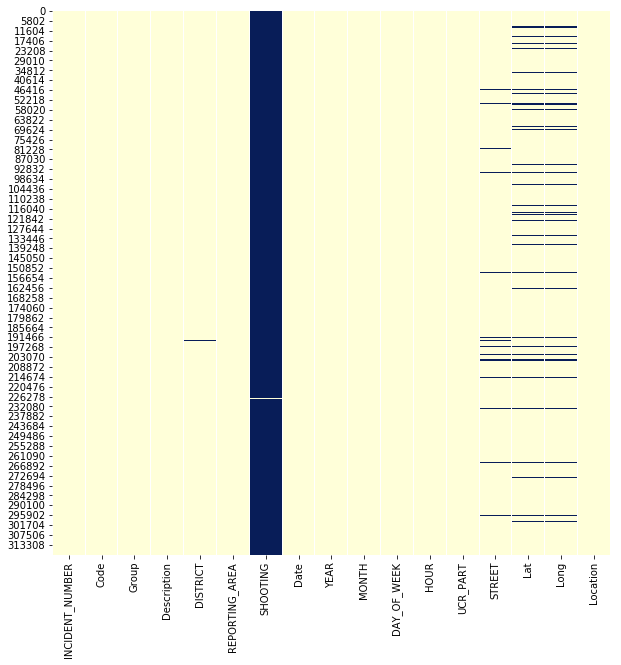

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(data1.isnull(),cbar=False,cmap='YlGnBu')
plt.ioff()

All the horizontal lines show the missing data in the dataset.Let us clean up the missing data by dropping the columns with missing data.Also the columns getting dropped will not have an affect on the forecasting of the crime.

#### Dropping the unwanted columns

In [8]:
data1.drop(['INCIDENT_NUMBER','Code','SHOOTING','UCR_PART','Lat','Long','Location'],inplace=True,axis=1)
data1.head()

,Group,Description,DISTRICT,REPORTING_AREA,Date,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET
0,Larceny,LARCENY ALL OTHERS,D14,808,2018-09-02 13:00:00,2018,9,Sunday,13,LINCOLN ST
1,Vandalism,VANDALISM,C11,347,2018-08-21 00:00:00,2018,8,Tuesday,0,HECLA ST
2,Towed,TOWED MOTOR VEHICLE,D4,151,2018-09-03 19:27:00,2018,9,Monday,19,CAZENOVE ST
3,Investigate Property,INVESTIGATE PROPERTY,D4,272,2018-09-03 21:16:00,2018,9,Monday,21,NEWCOMB ST
4,Investigate Property,INVESTIGATE PROPERTY,B3,421,2018-09-03 21:05:00,2018,9,Monday,21,DELHI ST


#### Arranging the date in datetime format

In [9]:
data1['Date']=pd.to_datetime(data1['Date'])
data1.head()

,Group,Description,DISTRICT,REPORTING_AREA,Date,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET
0,Larceny,LARCENY ALL OTHERS,D14,808,2018-09-02 13:00:00,2018,9,Sunday,13,LINCOLN ST
1,Vandalism,VANDALISM,C11,347,2018-08-21 00:00:00,2018,8,Tuesday,0,HECLA ST
2,Towed,TOWED MOTOR VEHICLE,D4,151,2018-09-03 19:27:00,2018,9,Monday,19,CAZENOVE ST
3,Investigate Property,INVESTIGATE PROPERTY,D4,272,2018-09-03 21:16:00,2018,9,Monday,21,NEWCOMB ST
4,Investigate Property,INVESTIGATE PROPERTY,B3,421,2018-09-03 21:05:00,2018,9,Monday,21,DELHI ST


In [10]:
data1.Date

0        2018-09-02 13:00:00
1        2018-08-21 00:00:00
2        2018-09-03 19:27:00
3        2018-09-03 21:16:00
4        2018-09-03 21:05:00
                 ...        
319068   2016-06-05 17:25:00
319069   2015-07-09 13:38:00
319070   2015-07-09 13:38:00
319071   2016-05-31 19:35:00
319072   2015-06-22 00:12:00
Name: Date, Length: 319073, dtype: datetime64[ns]

In [11]:
data1.index=pd.DatetimeIndex(data1.Date)
data1.head()

,Group,Description,DISTRICT,REPORTING_AREA,Date,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET
Date,,,,,,,,,,
2018-09-02 13:00:00,Larceny,LARCENY ALL OTHERS,D14,808,2018-09-02 13:00:00,2018,9,Sunday,13,LINCOLN ST
2018-08-21 00:00:00,Vandalism,VANDALISM,C11,347,2018-08-21 00:00:00,2018,8,Tuesday,0,HECLA ST
2018-09-03 19:27:00,Towed,TOWED MOTOR VEHICLE,D4,151,2018-09-03 19:27:00,2018,9,Monday,19,CAZENOVE ST
2018-09-03 21:16:00,Investigate Property,INVESTIGATE PROPERTY,D4,272,2018-09-03 21:16:00,2018,9,Monday,21,NEWCOMB ST
2018-09-03 21:05:00,Investigate Property,INVESTIGATE PROPERTY,B3,421,2018-09-03 21:05:00,2018,9,Monday,21,DELHI ST


#### Getting information most recurring Crime

In [12]:
data1['Group'].value_counts()

Motor Vehicle Accident Response              37132
Larceny                                      25935
Medical Assistance                           23540
Investigate Person                           18750
Other                                        18075
                                             ...  
HUMAN TRAFFICKING                                7
INVESTIGATE PERSON                               4
Biological Threat                                2
HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE        2
Burglary - No Property Taken                     2
Name: Group, Length: 67, dtype: int64

In [13]:
data1['Group'].value_counts().iloc[:15]

Motor Vehicle Accident Response    37132
Larceny                            25935
Medical Assistance                 23540
Investigate Person                 18750
Other                              18075
Drug Violation                     16548
Simple Assault                     15826
Vandalism                          15415
Verbal Disputes                    13099
Towed                              11287
Investigate Property               11124
Larceny From Motor Vehicle         10847
Property Lost                       9751
Warrant Arrests                     8407
Aggravated Assault                  7807
Name: Group, dtype: int64

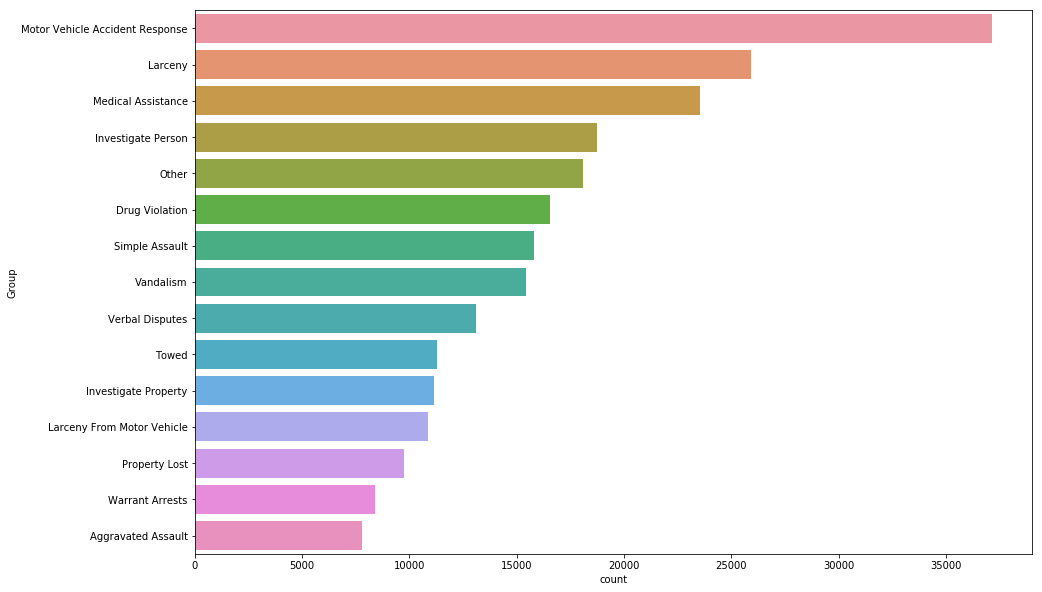

In [14]:
order_data=data1['Group'].value_counts().iloc[:15].index
plt.figure(figsize=(15,10))
sns.countplot(y='Group',data=data1,order=order_data)
plt.ioff()

So we can clearly see that the motor vehicle accident,theft and medical assistance are most crime indidents reported in Boston.

#### Resampling the data: 
This is done to segregate the crime count based on time period like month,quarter and year

In [15]:
data1.resample('Y').size()

Date
2015-12-31     53388
2016-12-31     99114
2017-12-31    100886
2018-12-31     65685
Freq: A-DEC, dtype: int64

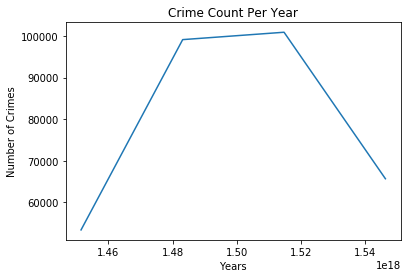

In [16]:
plt.plot(data1.resample('Y').size())
plt.title('Crime Count Per Year')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')
plt.ioff()

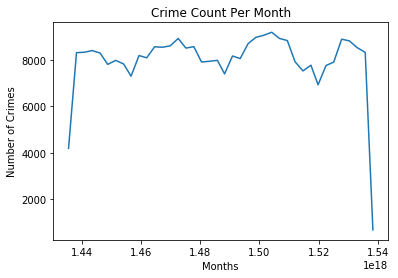

In [17]:
plt.plot(data1.resample('M').size())
plt.title('Crime Count Per Month')
plt.xlabel('Months')
plt.ylabel('Number of Crimes')
plt.ioff()

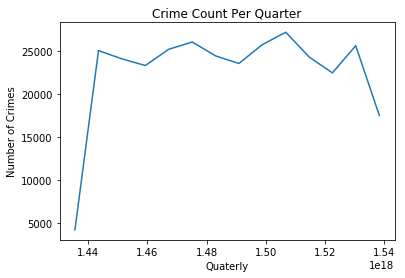

In [18]:
plt.plot(data1.resample('Q').size())
plt.title('Crime Count Per Quarter')
plt.xlabel('Quaterly')
plt.ylabel('Number of Crimes')
plt.ioff()

The X axis values and not getting displayed correctly.I am not sure why ? May be someone can throw some light on what needs to be done

#### Preparing the data 

In [19]:
Boston_prophet=data1.resample('M').size().reset_index()

In [20]:
Boston_prophet.head()

,Date,0
0,2015-06-30,4191
1,2015-07-31,8324
2,2015-08-31,8342
3,2015-09-30,8414
4,2015-10-31,8308


#### Renaming the columns of Boston_prophet

In [21]:
Boston_prophet.columns=['Date','Crime_Count']

In [22]:
Boston_prophet.head()

,Date,Crime_Count
0,2015-06-30,4191
1,2015-07-31,8324
2,2015-08-31,8342
3,2015-09-30,8414
4,2015-10-31,8308


In [23]:
Boston_prophet_final=Boston_prophet.rename(columns={'Date':'ds','Crime_Count':'y'})

In [24]:
Boston_prophet_final.head()

,ds,y
0,2015-06-30,4191
1,2015-07-31,8324
2,2015-08-31,8342
3,2015-09-30,8414
4,2015-10-31,8308


#### Make Predictions

In [25]:
m=Prophet()
m.fit(Boston_prophet_final)

In [26]:
future=m.make_future_dataframe(periods=365)
forecast=m.predict(future)

In [27]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-06-30,8503.439758,4768.607085,7772.604548,8503.439758,8503.439758,-2151.040465,-2151.040465,-2151.040465,-2151.040465,-2151.040465,-2151.040465,0.0,0.0,0.0,6352.399293
1,2015-07-31,8489.822444,7665.498110,10790.215334,8489.822444,8489.822444,751.550150,751.550150,751.550150,751.550150,751.550150,751.550150,0.0,0.0,0.0,9241.372594
2,2015-08-31,8476.205129,7546.594487,10712.962501,8476.205129,8476.205129,735.825138,735.825138,735.825138,735.825138,735.825138,735.825138,0.0,0.0,0.0,9212.030267
3,2015-09-30,8463.027083,4771.678784,7771.956899,8463.027083,8463.027083,-2205.742834,-2205.742834,-2205.742834,-2205.742834,-2205.742834,-2205.742834,0.0,0.0,0.0,6257.284248
4,2015-10-31,8449.409768,7557.393869,10609.656446,8449.409768,8449.409768,698.097493,698.097493,698.097493,698.097493,698.097493,698.097493,0.0,0.0,0.0,9147.507261
5,2015-11-30,8436.231721,6938.611013,9817.607075,8436.231721,8436.231721,-95.153557,-95.153557,-95.153557,-95.153557,-95.153557,-95.153557,0.0,0.0,0.0,8341.078164
6,2015-12-31,8422.614407,6562.146400,9624.405901,8422.614407,8422.614407,-283.318510,-283.318510,-283.318510,-283.318510,-283.318510,-283.318510,0.0,0.0,0.0,8139.295896
7,2016-01-31,8408.997092,6373.240289,9329.087254,8408.997092,8408.997092,-580.722601,-580.722601,-580.722601,-580.722601,-580.722601,-580.722601,0.0,0.0,0.0,7828.274491
8,2016-02-29,8396.258314,6123.607376,9144.808223,8396.258314,8396.258314,-814.037636,-814.037636,-814.037636,-814.037636,-814.037636,-814.037636,0.0,0.0,0.0,7582.220677
9,2016-03-31,8382.640999,6778.254374,9867.664988,8382.640999,8382.640999,-17.009969,-17.009969,-17.009969,-17.009969,-17.009969,-17.009969,0.0,0.0,0.0,8365.631030


In [28]:
#figure=m.plot(forecast,xlabel='Data',ylabel='Crime Rate')

In [29]:
#figure=m.plot_components(forecast)